<a href="https://colab.research.google.com/github/sandhyaparna/NLP/blob/main/Take%20Home%20Assignments/Dell_Boston_Bombing_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.simplefilter('ignore')

In [45]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)

In [65]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, re, os
from collections import defaultdict, Counter
from nltk.corpus import stopwords

In [3]:
# upload data 
from google.colab import files
uploaded = files.upload()

Saving boston_bombing_tweets - Home test Data Scientist.csv to boston_bombing_tweets - Home test Data Scientist.csv


In [4]:
import io
boston_bombing_tweets = pd.read_csv(io.BytesIO(uploaded['boston_bombing_tweets - Home test Data Scientist.csv']))
print(f'Tweets data is loaded')

Tweets data is loaded


In [46]:
boston_bombing_tweets.head()

,text,label
0,"#Job #Boston Site Supervisor / Lead Carpenter: MA-Boston, We are currently seeking a Site Supervisor / Lead Ca... http://t.co/rEzfWIYIfy",NaN
1,"RT @wilw NBC reporting suspect alive and in custody. CNN reporting that Quint, Sheriff Brody, unknown bearded man (poss terrorist?) still on boat.",1.0
2,#BostonMararthon suspect Dzhokhar Tsarnaev is in custody http://t.co/ubNR5Lreqv http://t.co/ax7bDCIXRH,1.0
3,THANK YOU ?MT @Boston_Police: CAPTURED! The hunt is over. The search is done. The terror is over. And justice has won. Suspect in custody.,NaN
4,"RT @CNBCClosingBell The Boston College Center on Wealth & Philanthropy says $59T will be pat down to children, charity, taxes, etc. @robtfrank with the story.",NaN


In [174]:
tweets_train = boston_bombing_tweets[pd.notnull(boston_bombing_tweets.label)]
print("Number of observations in train data are", tweets_train.shape[0])

tweets_test = boston_bombing_tweets[pd.isnull(boston_bombing_tweets.label)]
print("Number of observations in test data are", tweets_test.shape[0])

Number of observations in train data are 4000
Number of observations in test data are 12218


### Explore train data
* Train data contains equal number of 1s and 0s - Balanced data

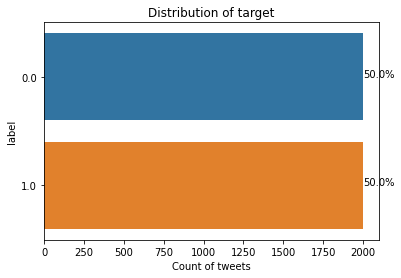

In [33]:
label_graph = sns.countplot(y="label", data=tweets_train)
plt.title('Distribution of target')
plt.xlabel('Count of tweets')

total = len(tweets_train['label'])
for p in label_graph.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        label_graph.annotate(percentage, (x, y))

plt.show()

In [31]:
print('The no of duplicates in the data:',tweets_train[tweets_train.duplicated(subset = ["text"], keep=False)].shape[0])

The no of duplicates in the data: 0


In [32]:
print("Number of missing values in the train data for each column:")
tweets_train.isnull().sum()

Number of missing values in the train data for each column:


text     0
label    0
dtype: int64

In [55]:
print("punctuations in string.punctuation",string.punctuation) 

tweets_train['punctuations'] = tweets_train["text"].apply(lambda x: re.findall('[%s]' % re.escape(string.punctuation),str(x)))  # Extracting any punctiations that in the variable column
tweets_train['punctuations_str'] = [','.join(map(str, l)) for l in tweets_train['punctuations']]  # convert punctuations to strings
punctuations_uq = set(','.join(tweets_train['punctuations_str'].apply(lambda x: str(x))))  # generates unique punctuations by creating a string from punctuations_str column generated
list(punctuations_uq)

punctuations in string.punctuation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


['&',
 '*',
 '.',
 '/',
 '!',
 '^',
 '>',
 '_',
 ';',
 '-',
 '%',
 '#',
 ':',
 '|',
 '~',
 ')',
 '=',
 ']',
 ',',
 '"',
 '@',
 '?',
 '$',
 '\\',
 "'",
 '<',
 '+',
 '(',
 '[']

In [53]:
tweets_train['punctuations_uq'] = tweets_train['punctuations'].apply(lambda x: set(x))

In [54]:
tweets_train.head()

,text,label,punctuations,punctuations_str,punctuations_uq
1,"RT @wilw NBC reporting suspect alive and in custody. CNN reporting that Quint, Sheriff Brody, unknown bearded man (poss terrorist?) still on boat.",1.0,"[@, ., ,, ,, (, ?, ), .]","@,.,,,,,(,?,),.","{(, ., ,, @, ?, )}"
2,#BostonMararthon suspect Dzhokhar Tsarnaev is in custody http://t.co/ubNR5Lreqv http://t.co/ax7bDCIXRH,1.0,"[#, :, /, /, ., /, :, /, /, ., /]","#,:,/,/,.,/,:,/,/,.,/","{#, :, /, .}"
6,RT @BreitbartNews Margaret Thatcher Remembered America in the Midst of Terror: President Barack Obama is fond of challenging Ame... http://t.co/3kdeg3ooAv,1.0,"[@, :, ., ., ., :, /, /, ., /]","@,:,.,.,.,:,/,/,.,/","{:, ., @, /}"
15,Spontaneous celebrations in streets of #Watertown #Boston. This is how my 91 yr old Dad describes V-E Day. One battle in War on Terror won.,1.0,"[#, #, ., -, ., .]","#,#,.,-,.,.","{#, ., -}"
25,"#Bostonsgigs Looking for someone for dishwasher install (Charlestown, Ma) http://t.co/BJQpvI5MfQ #Boston",0.0,"[#, (, ,, ), :, /, /, ., /, #]","#,(,,,),:,/,/,.,/,#","{(, ., /, ,, #, :, )}"


In [295]:
def create_corpus(target):
    corpus=[]
    
    for x in tweets_train[tweets_train['label']==target]['Text_Var'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 16 artists>

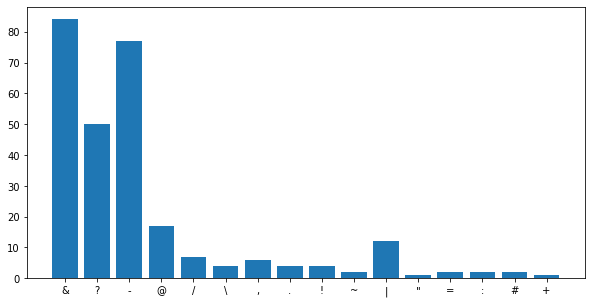

In [59]:
# Analyzing punctuations in label=1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 19 artists>

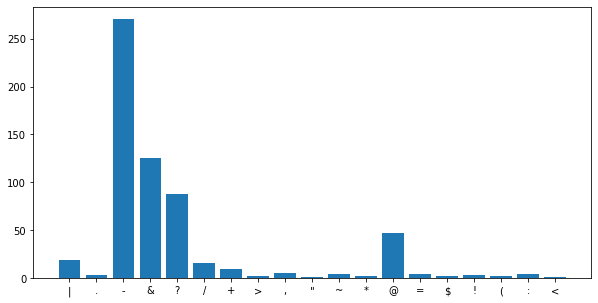

In [60]:
# Analyzing punctuations in label=0
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

In [67]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

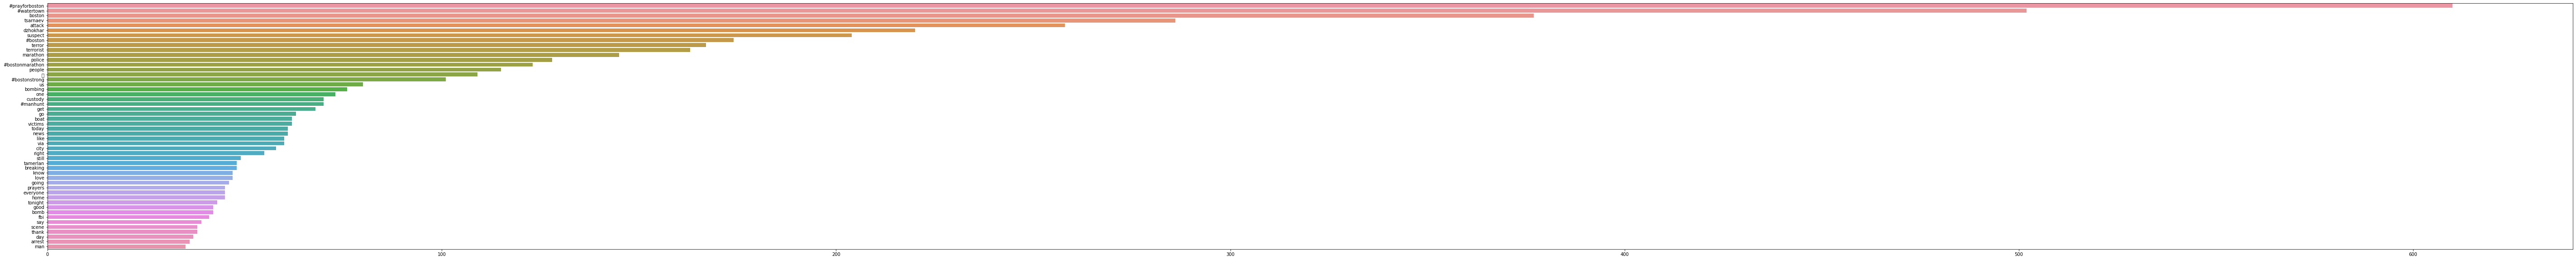

<Figure size 720x360 with 0 Axes>

In [333]:
corpus=create_corpus(1)
stop=set(stopwords.words('english'))

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:50]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.figure(figsize=(10, 5))
plt.show()

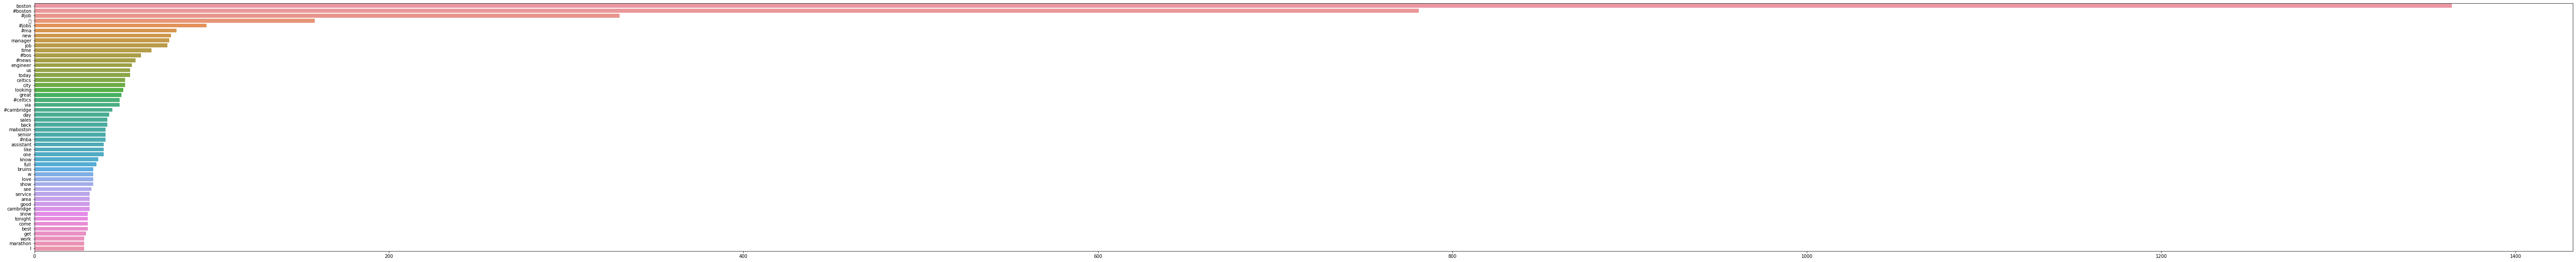

<Figure size 720x360 with 0 Axes>

In [334]:
corpus=create_corpus(0)
stop=set(stopwords.words('english'))

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:50]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.figure(figsize=(10, 5))
plt.show()

In [80]:
print()
tweets_train['URL_present'] = np.where(tweets_train['text'].str.contains("http://"),1,0)
pd.crosstab(tweets_train["label"],tweets_train['URL_present'])

In [98]:
tweets_train['RT_present'] = np.where(tweets_train.text.str.split().str[0] == "RT",1, 0)
pd.crosstab(tweets_train["label"],tweets_train['RT_present'])

RT_present,0,1
label,,
0.0,1582,418
1.0,1062,938


In [ ]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
tweets_train['hash']=tweets_train['Text_Var'].apply(lambda x:find_hash(x))
temp=tweets_train['hash'].value_counts()[:][1:20]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)
plt.xticks(rotation=70)
plt.tight_layout()


In [356]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
tweets_train['hash']=tweets_train['Text_Var'].apply(lambda x:find_hash(x))
temp=tweets_train['hash'].value_counts()[:][1:500]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})

temp_corpus = []
for x in temp['Hashtag'].str.split():
    for i in x:
        temp_corpus.append(i)
cnt = 0
for i, j in dict(Counter(temp_corpus)).items():
  if j>=2:
    cnt += 1
    print(i,j)

print(cnt)

prayforboston 113
watertown 71
boston 180
job 13
jobs 11
news 6
bos 2
ma 7
bostonmarathon 37
cambridge 5
manhunt 18
bostonstrong 31
bruins 6
nhl 2
bostonbombings 7
massachusetts 2
wbz 7
bpd 2
scanner 2
wcvb 7
prayfortexas 7
celtics 8
basketball 4
nba 7
collectibles 2
redsox 12
arena 2
deals 4
oneboston 4
bosnow 4
breaking 3
mlb 5
tickets 2
ticket 2
mbta 6
tbt 2
bostonmanhunt 4
mitshooting 4
fbi 3
dzhokhar 3
bostonbombing 8
usa 2
tsarnaev 3
np 2
marathon 3
breakingnews 2
prayfortheworld 2
presidentobama 2
brookline 2
class 2
fashion 2
backbay 2
beaconhill 2
hometown 2
prayersforboston 2
prayformycity 2
travel 2
musicmonday 2
peace 2
love 4
prayingforboston 2
weareboston 6
rip 3
runforboston 3
music 5
radio 2
live 2
talk 3
wemf 3
songs 2
dreams 2
hope 2
cre 2
startup 2
standtogether 2
dzhokhartsarnaev 2
bostonmararthon 2
tech 2
events 2
interfaith 2
bostonyouremyhome 2
obama 2
runners 2
weather 4
mawx 2
sales 2
proud 2
bostonhiphop 2
bostonrap 2
myhome 2
hiphop 2
nightlife 2
snow 2
histo

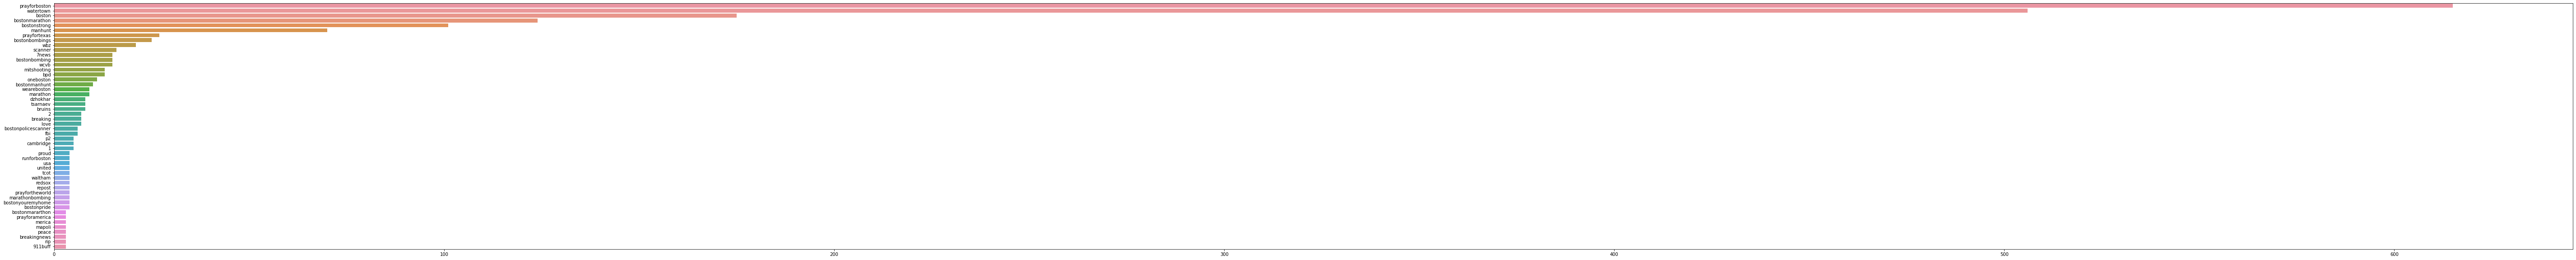

<Figure size 1800x360 with 0 Axes>

In [215]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
tweets_train['hash']=tweets_train['Text_Var'].apply(lambda x:find_hash(x))

# Extract hashtags
hash_corpus = []
for x in tweets_train[tweets_train.label==1]['hash'].str.split():
    for i in x:
        hash_corpus.append(i)
        
hash_corpus_counter = Counter(hash_corpus)
most=hash_corpus_counter.most_common()
x=[]
y=[]
for word,count in most[:50]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.figure(figsize=(25, 5))
plt.show()

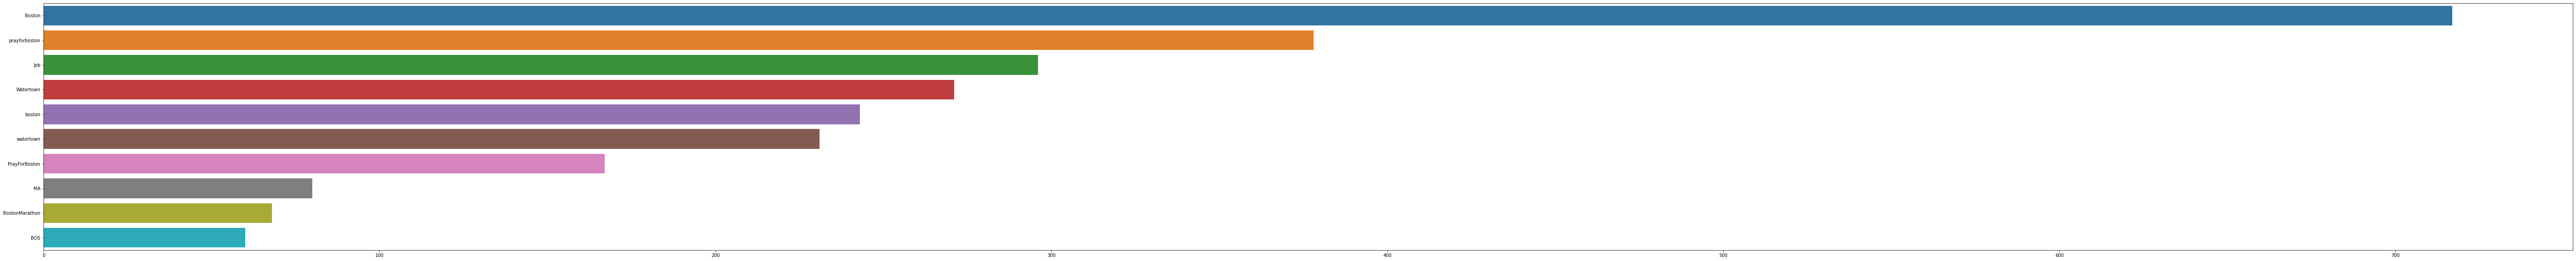

<Figure size 720x360 with 0 Axes>

In [161]:
# Extract hashtags
hash_corpus = []
for x in tweets_train['hash'].str.split():
    for i in x:
        hash_corpus.append(i)
        
hash_corpus_counter = Counter(hash_corpus)
most=hash_corpus_counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.figure(figsize=(10, 5))
plt.show()

In [332]:
tweets_train.head(10)

,text,label,Text_Var,hash,chk
1,"RT @wilw NBC reporting suspect alive and in custody. CNN reporting that Quint, Sheriff Brody, unknown bearded man (poss terrorist?) still on boat.",1.0,nbc reporting suspect alive custody cnn reporting quint sheriff brody unknown bearded man poss terrorist still boat,,[]
2,#BostonMararthon suspect Dzhokhar Tsarnaev is in custody http://t.co/ubNR5Lreqv http://t.co/ax7bDCIXRH,1.0,#bostonmararthon suspect dzhokhar tsarnaev custody,bostonmararthon,[]
6,RT @BreitbartNews Margaret Thatcher Remembered America in the Midst of Terror: President Barack Obama is fond of challenging Ame... http://t.co/3kdeg3ooAv,1.0,margaret thatcher remembered america midst terror president barack obama fond challenging ame,,[]
15,Spontaneous celebrations in streets of #Watertown #Boston. This is how my 91 yr old Dad describes V-E Day. One battle in War on Terror won.,1.0,spontaneous celebrations streets #watertown #boston yr old dad describes day one battle war terror,watertown boston,[]
25,"#Bostonsgigs Looking for someone for dishwasher install (Charlestown, Ma) http://t.co/BJQpvI5MfQ #Boston",0.0,#bostonsgigs looking someone dishwasher install charlestown #boston,bostonsgigs boston,[]
27,Suspect #2 is in custody.. Putting him in the ambulance #Boston #watertown,1.0,suspect custody putting ambulance #boston #watertown,2 boston watertown,[]
28,#Job #Cambridge Secret shopper position: Boston Dear Shoppers! We are accepting applications from qualified in... http://t.co/i7N4HWSH2L,0.0,#job #cambridge secret shopper position boston dear shoppers accepting applications qualified,job cambridge,[]
37,Boston bombs a ?sophisticated? attack http://t.co/50BTutzAR9,1.0,boston bombs sophisticated attack,,[]
42,RT @seankerrigan21 Let's not forget what makes this such a great country: things like due process & innocence until proven guilty. #watertown #bostonstrong,1.0,let us forget makes great country things like due process innocence proven guilty #watertown #bostonstrong,watertown bostonstrong,"[('et', 's')]"
44,"RT @MattBinder If they never find Dzhokhar Tsarnaev, does Boston just shut down forever?",1.0,never find dzhokhar tsarnaev boston shut forever,,[]


In [306]:
tweets_train['chk']=tweets_train['text'].apply(lambda x: re.findall(r"([a-z]+)'(s)",str(x)))
tweets_train['chk'] = tweets_train['chk'].astype(str)
check = tweets_train[tweets_train['chk'] != '[]']
check.shape

(438, 5)

In [ ]:
check.head(20)

In [ ]:
print(pd.value_counts(check.label))
# check.head(20)
corpus_chk = []
for x in tweets_train[tweets_train.label==1]['chk'].str.split():
    for i in x:
        corpus_chk.append(i)
        
Counter(corpus_chk)

### Data pre-processing
* Remove the word "RT ", if it is at the beginning of the text
* 

In [331]:
def replace_all(text, dic=replacements_dict):
    for i, j in dic.items():
        text = re.sub(i, j, text)
    return text
# replace text column by using contractions_dict & replace_all function
tweets_train['Text_Var'] = tweets_train['text'].str.lower()
tweets_train['Text_Var'] = tweets_train['Text_Var'].apply(lambda x: replace_all(x,replacements_dict))

stop_words = stopwords.words('english')
more_stopwords = ['i']
stop_words = stop_words + more_stopwords
    
def text_preprocess(text):
  '''remove the word 'rt @', make text lowercase, remove links, 
     remove mentions of username,
     remove punctuation except #,
    and remove words containing numbers.'''
  text = re.sub('[%s]' % re.escape(string.punctuation.replace('#','')), '', text)
  text = re.sub('^# |# ', '', text)
  text = re.sub('[^\u0000-\u007e]+', '', text)
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  return text
  
# tweets_train['Text_Var'] = tweets_train['Text_Var'].apply(lambda x: ' '.join(word for word in x.split(' ') if word not in stop_words))
tweets_train["Text_Var"] = tweets_train["Text_Var"].apply(text_preprocess)

In [301]:


def text_preprocess(text):
  '''remove the word 'RT @', make text lowercase, remove links, 
     remove mentions of username,
     remove punctuation except #,
    and remove words containing numbers.'''
  text = re.sub('RT @', '@', text)
  text = str(text).lower()
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('(?<=)@\w+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation.replace('#','')), '', text)
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)
  text = re.sub('([a-z]+\d+[a-z]+\d+[a-z]+)|(\d+[a-z]+\d+[a-z]+\d+)|([a-z]+\d+[a-z]+\d+)|(\d+[a-z]+\d+[a-z]+)|(\d+[a-z]+\d+)|([a-z]+\d+[a-z]+)|([a-z]+\d+)|(\d+[a-z]+)|\d+', '', text)
  return text

In [302]:
tweets_train["Text_Var"] = tweets_train["text"].apply(text_preprocess)

In [123]:
tweets_train["Text_Var"] = tweets_train["text"].str.replace(r'RT @', '@')
tweets_train["Text_Var"] = tweets_train["Text_Var"].str.replace(r'https?://\S+|www\.\S+', '')
tweets_train["Text_Var"] = tweets_train["Text_Var"].str.replace(r'(?<=)@\w+', '')



In [148]:
# length of the text
tweets_train["Text_Length"] = tweets_train["Text_Var"].str.len()

In [124]:
tweets_train[["text","Text_Var"]].head(15)

,text,Text_Var
1,"RT @wilw NBC reporting suspect alive and in custody. CNN reporting that Quint, Sheriff Brody, unknown bearded man (poss terrorist?) still on boat.","NBC reporting suspect alive and in custody. CNN reporting that Quint, Sheriff Brody, unknown bearded man (poss terrorist?) still on boat."
2,#BostonMararthon suspect Dzhokhar Tsarnaev is in custody http://t.co/ubNR5Lreqv http://t.co/ax7bDCIXRH,#BostonMararthon suspect Dzhokhar Tsarnaev is in custody
6,RT @BreitbartNews Margaret Thatcher Remembered America in the Midst of Terror: President Barack Obama is fond of challenging Ame... http://t.co/3kdeg3ooAv,Margaret Thatcher Remembered America in the Midst of Terror: President Barack Obama is fond of challenging Ame...
15,Spontaneous celebrations in streets of #Watertown #Boston. This is how my 91 yr old Dad describes V-E Day. One battle in War on Terror won.,Spontaneous celebrations in streets of #Watertown #Boston. This is how my 91 yr old Dad describes V-E Day. One battle in War on Terror won.
25,"#Bostonsgigs Looking for someone for dishwasher install (Charlestown, Ma) http://t.co/BJQpvI5MfQ #Boston","#Bostonsgigs Looking for someone for dishwasher install (Charlestown, Ma) #Boston"
27,Suspect #2 is in custody.. Putting him in the ambulance #Boston #watertown,Suspect #2 is in custody.. Putting him in the ambulance #Boston #watertown
28,#Job #Cambridge Secret shopper position: Boston Dear Shoppers! We are accepting applications from qualified in... http://t.co/i7N4HWSH2L,#Job #Cambridge Secret shopper position: Boston Dear Shoppers! We are accepting applications from qualified in...
37,Boston bombs a ?sophisticated? attack http://t.co/50BTutzAR9,Boston bombs a ?sophisticated? attack
42,RT @seankerrigan21 Let's not forget what makes this such a great country: things like due process & innocence until proven guilty. #watertown #bostonstrong,Let's not forget what makes this such a great country: things like due process & innocence until proven guilty. #watertown #bostonstrong
44,"RT @MattBinder If they never find Dzhokhar Tsarnaev, does Boston just shut down forever?","If they never find Dzhokhar Tsarnaev, does Boston just shut down forever?"


In [329]:
replacements_dict = {"'cause": "because",
"'tis": "it is",
"'twas": "it was",
"ain't": "are not",
"amn't": "am not",
"aren't": "are not",
"can't've": "can not have",
"can't": "can not",
"could've": "could have",
"couldn't've": "could not have",
"couldn't": "could not",
"daren't": "dare not",
"daresn't": "dare not",
"dasn't": "dare not",
"didn't": "did not",
"didn’t": "did not",
"doesn't": "does not",
"don't": "do not",
"don’t": "do not",
"e'er": "ever",
"everyone's": "everyone is",
"finna": "fixing to",
"gimme": "give me",
"gon't": "go not",
"gonna": "going to",
"gotta": "got to",
"hadn't've": "had not have",
"hadn't": "had not",
"hasn't": "has not",
"haven't": "have not",
"he'd've": "he would have",
"he'd": "he would",
"he'll've": "he will have",
"he'll": "he will",
"he's": "he is",
"he've": "he have",
"here's": "here is",
"how'd'y": "how do you",
"how'd": "how did",
"how'll": "how will",
"how're": "how are",
"how's": "how is",
"i'd've": "i would have",
"i'd": "i would",
"i'll've": "i will have",
"i'll": "i will",
"i'm'a": "i am about to",
"i'm'o": "i am going to",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd've": "it would have",
"it'd": "it would",
"it'll've": "it will have",
"it'll": "it will",
"it's": "it is",
"kinda": "kind of",
"let's": "let us",
"luv": "love",
"ma'am": "madam",
"may've": "may have",
"mayn't": "may not",
"might've": "might have",
"mightn't've": "might not have",
"mightn't": "might not",
"must've": "must have",
"mustn't've": "must not have",
"mustn't": "must not",
"ne'er": "never",
"needn't've": "need not have",
"needn't": "need not",
"o'": "of",
"o'clock": "of the clock",
"o'er": "over",
"ol'": "old",
"oughtn't've": "ought not have",
"oughtn't": "ought not",
"sha'n't": "shall not",
"shalln't": "shall not",
"shan't've": "shall not have",
"shan't": "shall not",
"she'd've": "she would have",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't've": "should not have",
"shouldn't": "should not",
"so's": "so is",
"so've": "so have",
"somebody's": "somebody is",
"someone's": "someone is",
"something's": "something is",
"that'd've": "that would have",
"that'd": "that would",
"that'll": "that will",
"that're": "that are",
"that's": "that is",
"there'd've": "there would have",
"there'd": "there would",
"there'll": "there will",
"there're": "there are",
"there's": "there is",
"these're": "these are",
"they'd've": "they would have",
"they'd": "they would",
"they'll've": "they will have",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"this's": "this is",
"those're": "those are",
"to've": "to have",
"wanna": "want to",
"wasn't": "was not",
"we'd've": "we would have",
"we'd": "we would",
"we'll've": "we will have",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'd": "what did",
"what'll've": "what will have",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"whatcha": "what are you",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where're": "where are",
"where's": "where is",
"where've": "where have",
"which's": "which is",
"who'd've": "who would have",
"who'd": "who would",
"who'll've": "who will have",
"who'll": "who will",
"who're": "who are",
"who's": "who is",
"who've": "who have",
"why'd": "why did",
"why're": "why are",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't've": "will not have",
"won't": "will not",
"would've": "would have",
"wouldn't've": "would not have",
"wouldn't": "would not",
"y'all'd've": "you all would have",
"y'all'd": "you all would",
"y'all're": "you all are",
"y'all've": "you all have",
"y'all": "you all",
"you'd've": "you would have",
"you'd": "you would",
"you'll've": "you shall have",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
"([a-z]+)'(s)": "\1",
'rt @': '@',
'https?://\S+|www\.\S+': '',
'(?<=)@\w+': '',
'([a-z]+\d+[a-z]+\d+[a-z]+)|(\d+[a-z]+\d+[a-z]+\d+)|([a-z]+\d+[a-z]+\d+)|(\d+[a-z]+\d+[a-z]+)|(\d+[a-z]+\d+)|([a-z]+\d+[a-z]+)|([a-z]+\d+)|(\d+[a-z]+)|\d+': '',
'jobs': 'job'}